In [255]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [256]:
import pandas as pd
import numpy as np
from bayesian.train_bn import structure_learning, parameter_learning, parameter_learning_mix
from preprocess.discretization import get_nodes_type, discretization, inverse_discretization, code_categories
from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from visualization.visualization import draw_BN
from bayesian.calculate_accuracy import calculate_acc
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from copy import copy
from external.libpgm.sampleaggregator import SampleAggregator
import operator
from sklearn.metrics import accuracy_score, mean_squared_error
from scipy import stats
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
import math
from pomegranate import DiscreteDistribution
import random
from sklearn.model_selection import train_test_split
import matplotlib.ticker as ticker

In [407]:
geo_rmse = pd.read_csv('sangiovese_results_cont.csv')

In [385]:
average_rmse_simple_evo = pd.DataFrame(columns=['Parameter', 'RMSE decrease %', 'Alg'])
average_rmse_simple_hc = pd.DataFrame(columns=['Parameter', 'RMSE decrease %', 'Alg'])

In [386]:
geo_hc = geo_rmse.loc[geo_rmse['Strategy'] == 'HC']
geo_evo = geo_rmse.loc[geo_rmse['Strategy'] == 'evo']
base_hc = geo_hc.loc[geo_hc['Alg'] == 'D+D']
base_evo = geo_evo.loc[geo_evo['Alg'] == 'D+D']
for i in range(geo_hc.shape[0]):
    row_hc = geo_hc.iloc[i,:]
    row_evo = geo_evo.iloc[i,:]
    if (row_hc['Alg'] != 'D+D') & (row_hc['Parameter'] != 'blh'):
        base_hc_param = pd.DataFrame(base_hc.loc[base_hc['Parameter'] == row_hc['Parameter']])
        base_evo_param = pd.DataFrame(base_evo.loc[base_evo['Parameter'] == row_evo['Parameter']])
        m1 = 100 - ((100*row_hc['rmse'])/base_hc_param['rmse'].values)
        m2 = 100 - ((100*row_evo['rmse'])/base_evo_param['rmse'].values)
        average_rmse_simple_hc = average_rmse_simple_hc.append({'Parameter':row_hc['Parameter'], 'RMSE decrease %': m1[0], 'Alg':row_hc['Alg'] + ' hc'}, ignore_index=True)
        average_rmse_simple_evo = average_rmse_simple_evo.append({'Parameter':row_evo['Parameter'], 'RMSE decrease %': m2[0], 'Alg':row_evo['Alg']+ ' evo'}, ignore_index=True)
    


In [387]:
full_rmse = pd.concat([average_rmse_simple_hc, average_rmse_simple_evo])

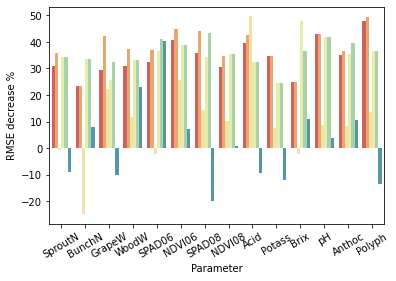

In [388]:

ax = sns.barplot(data=full_rmse, x="Parameter", y="RMSE decrease %", hue="Alg", palette="Spectral")
#sns.barplot(data=average_rmse_simple_evo, x="Parameter", y="RMSE decrease %", hue="Alg", palette="Blues")

#sns.barplot(data=average_rmse_simple_hc, x="Parameter", y="RMSE decrease %", hue="Alg", palette="Reds")

ax.xaxis.set_tick_params(rotation=30)
plt.legend([],[], frameon=False)
# ax2.xaxis.set_tick_params(rotation=10)
#plt.legend(loc='upper right')

In [408]:
average_rmse_simple = pd.DataFrame(columns=['Parameter', 'RMSE difference %', 'Alg'])


In [409]:
geo_hc = geo_rmse.loc[geo_rmse['Strategy'] == 'HC']
geo_evo = geo_rmse.loc[geo_rmse['Strategy'] == 'evo']
for i in range(geo_hc.shape[0]):
    row_hc = geo_hc.iloc[i,:]
    row_evo = geo_evo.iloc[i,:]
    if row_hc['Parameter'] != 'blh':
        m = ((100*row_evo['rmse'])/row_hc['rmse']) - 100
        if m > 1000:
            m = 100
        average_rmse_simple = average_rmse_simple.append({'Parameter':row_hc['Parameter'], 'RMSE difference %': m, 'Alg':row_hc['Alg']}, ignore_index=True)
    
    


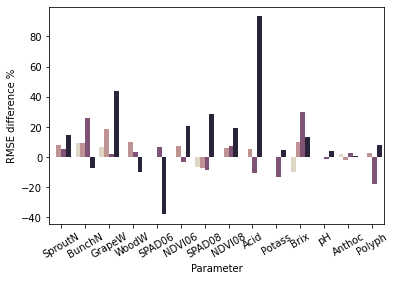

In [410]:
ax = sns.barplot(data=average_rmse_simple, x="Parameter", y="RMSE difference %", hue="Alg", palette="ch:s=-.2,r=.6")

ax.xaxis.set_tick_params(rotation=30)
plt.legend([],[], frameon=False)


In [289]:
geo_hc

,Parameter,Strategy,Alg,rmse
0,D,HC,D+M,2.600000
1,I,HC,D+M,1121.990000
2,O,HC,D+M,110.760000
3,T,HC,D+M,1158.740000
4,D,HC,M+M,2.590000
5,I,HC,M+M,1117.560000
6,O,HC,M+M,110.730000
7,T,HC,M+M,1161.320000
8,D,HC,D+D,2.470314
9,I,HC,D+D,2075.140265


In [290]:
geo_evo

,Parameter,Strategy,Alg,rmse
16,D,evo,D+M,2.650000
17,I,evo,D+M,1064.900000
18,O,evo,D+M,42.130000
19,T,evo,D+M,112.270000
20,D,evo,M+M,2.650000
21,I,evo,M+M,10.180000
22,O,evo,M+M,95.800000
23,T,evo,M+M,426.220000
24,D,evo,D+D,2.470314
25,I,evo,D+D,395.189094
